In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

train_df = pd.read_csv('DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)
test_df = pd.read_csv('DailyDelhiClimateTest.csv', index_col='date', parse_dates=True)

train_df = train_df.dropna()
test_df = test_df.dropna()

train_df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


In [2]:
test_df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...
2018-10-27,24.750000,54.250000,3.475000,1013.875000
2018-10-28,20.875000,57.250000,7.875000,1015.875000
2018-10-29,22.125000,63.500000,1.850000,1016.875000


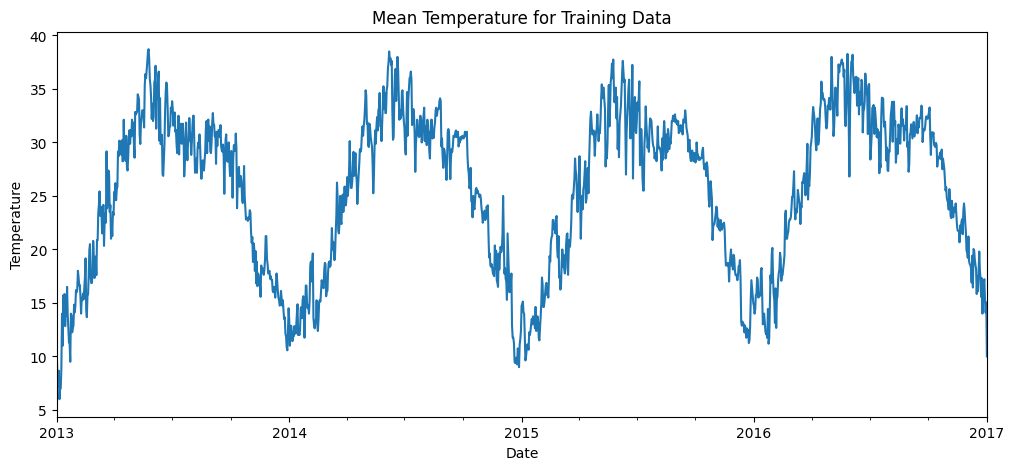

In [3]:
train_df['meantemp'].plot(figsize=(12, 5))
plt.title('Mean Temperature for Training Data')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

In [4]:
# Preprocess the training data
train_data = train_df['meantemp'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)

In [5]:
# Define sequence length
sequence_length = 30

In [6]:
# Prepare data for training
X_train, y_train = [], []
for i in range(len(train_data_scaled) - sequence_length):
    X_train.append(train_data_scaled[i:i+sequence_length, 0])
    y_train.append(train_data_scaled[i+sequence_length, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))   #(number of samples, sequence length=30, number of features=1)

In [7]:
# Preprocess the testing data
test_data = test_df['meantemp'].values.reshape(-1, 1)
test_data_scaled = scaler.transform(test_data)

In [8]:
X_test, y_test = [], []
for i in range(len(test_data_scaled) - sequence_length):
    X_test.append(test_data_scaled[i:i+sequence_length, 0])
    y_test.append(test_data_scaled[i+sequence_length, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1), activation="relu"))
model.add(Dense(7, activation="relu"))
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=30, validation_split=0.1, verbose=1)

# Make predictions on the testing data
test_predictions_scaled = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions_scaled).flatten()

Epoch 1/50
43/43 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 2/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 3/50
43/43 [==============================] - 0s 7ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 4/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 5/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 6/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 7/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 8/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 9/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 10/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 11/50
43/43 [

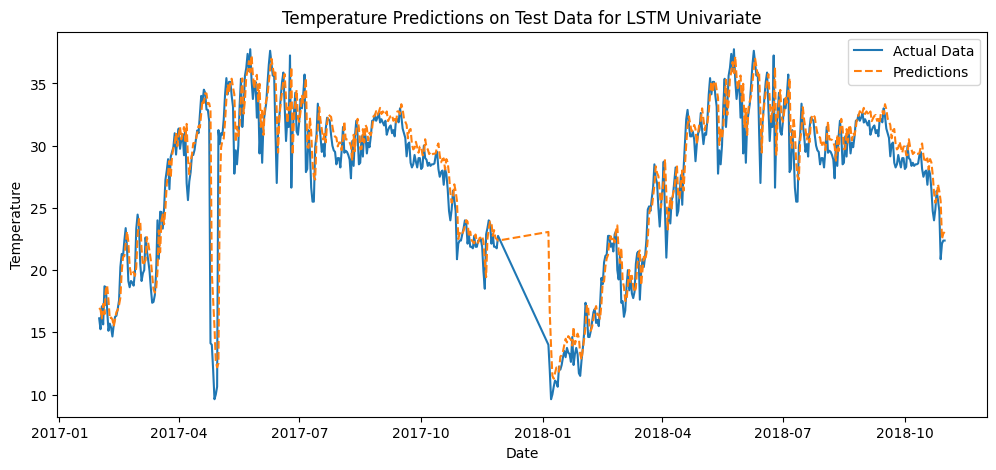

In [15]:
# Plotting predictions vs. actual for testing data
plt.figure(figsize=(12, 5))
plt.plot(test_df.index[sequence_length:], test_df['meantemp'].values[sequence_length:], label='Actual Data')
plt.plot(test_df.index[sequence_length:], test_predictions, label='Predictions', linestyle='dashed')
plt.title('Temperature Predictions on Test Data for LSTM Univariate')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(test_df['meantemp'].values[sequence_length:], test_predictions)
rmse = sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 2.1957500025370678


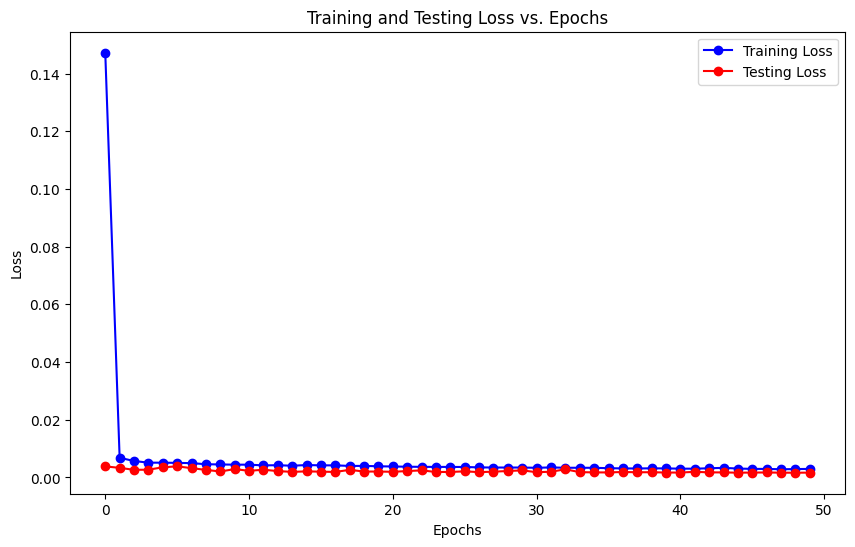

In [13]:
# Plotting Training and Testing Loss vs. Epochs
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], 'bo-', label='Training Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Testing Loss')
plt.title('Training and Testing Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
